In [12]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import sunpy.visualization.colormaps as cm
import cv2
import skimage
import glob
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import random

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

import autoenc_model as aem
import data_generator as dg
import utils

In [13]:
noise_filter = True

In [14]:
data_files = glob.glob("data/composite_data/2016*.npy")

data_matrix = np.empty([len(data_files),100,360,3])

for idx, data_file in enumerate(data_files):
    data_point = np.load(data_file)
    if data_point.shape[0] == 100:
        data_matrix[idx] = data_point
    else:
        print(data_point.shape, data_file)

data_matrix[:,:,:,0] = np.clip(data_matrix[:,:,:,0], 0, 5000)
data_matrix[:,:,:,1] = np.clip(data_matrix[:,:,:,1], 0, 3000)
data_matrix[:,:,:,2] = np.clip(data_matrix[:,:,:,2], -400, 400)

min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)

rg = max_values - min_values

rg = np.fmax(rg, 1e-4)

data_matrix_norm = (data_matrix-min_values) / rg

# Normalize HMI magnetogram data differently
hmi_max_values = np.nanmax(np.nanmax(np.abs(data_matrix[:,:,:,2]), axis=2, keepdims=True), axis=1, keepdims=True)

data_matrix_norm[:,:,:,2] = ((data_matrix[:,:,:,2] / hmi_max_values) + 1)/2

data_matrix_norm[np.isnan(data_matrix_norm)] = 0

# data_matrix_norm = (data_matrix_norm*2)-1

input_train, input_test = train_test_split(data_matrix_norm, test_size=0.25)

utils.range_tuple(data_matrix_norm)

(360, 100, 3) data/composite_data/2016-02-01T03-34-35.npy


/tmp/ipykernel_26006/828343979.py:16: RuntimeWarning: All-NaN slice encountered
  min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/tmp/ipykernel_26006/828343979.py:17: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/tmp/ipykernel_26006/828343979.py:26: RuntimeWarning: All-NaN slice encountered
  hmi_max_values = np.nanmax(np.nanmax(np.abs(data_matrix[:,:,:,2]), axis=2, keepdims=True), axis=1, keepdims=True)
/tmp/ipykernel_26006/828343979.py:28: RuntimeWarning: invalid value encountered in divide
  data_matrix_norm[:,:,:,2] = ((data_matrix[:,:,:,2] / hmi_max_values) + 1)/2


(0.0, 1.0)

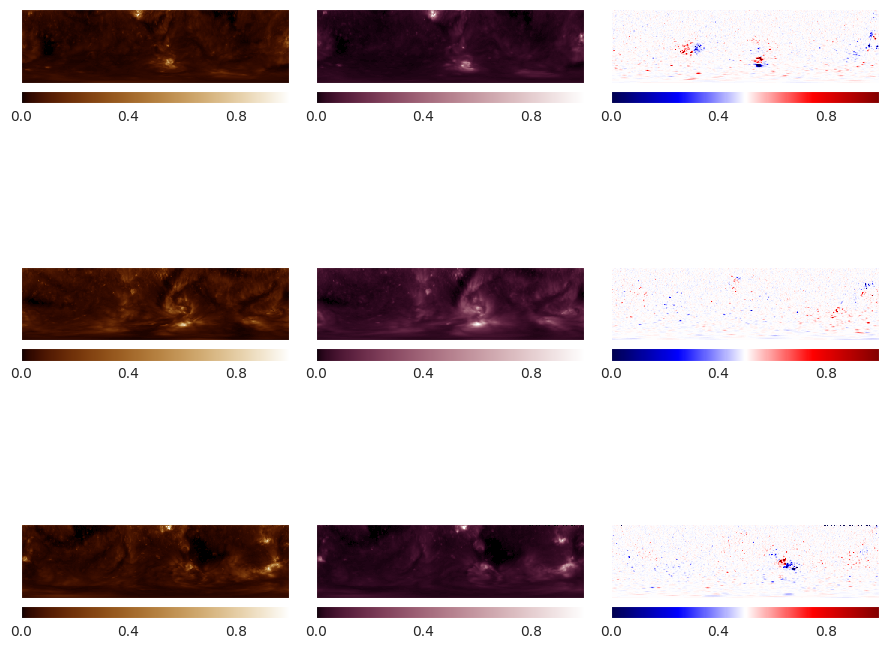

In [15]:
img_amount = 3

image_list = []
for data_image in data_matrix_norm[:img_amount]:
    for channel in data_image.transpose(2,0,1):
        image_list.append(channel)

isns.ImageGrid(image_list, cmap=["sdoaia193", "sdoaia211", "seismic"]*img_amount, orientation="h", vmin=0, vmax=1)

(200, 200) (100, 360)


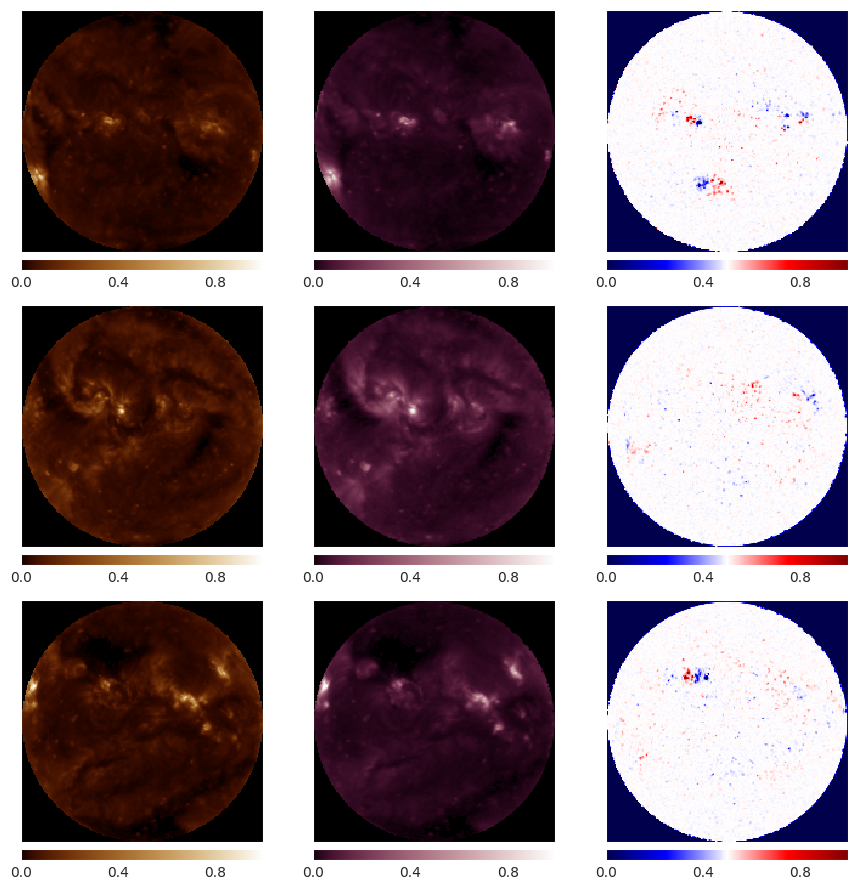

In [16]:
print(utils.polar_linear(image_list[0]).shape, image_list[0].shape)
ax = isns.ImageGrid(image_list.copy(), col_wrap=3, cmap=["sdoaia193", "sdoaia211", "seismic"]*img_amount, map_func=utils.polar_linear, orientation="h", vmin=0, vmax=1)

In [25]:
import math
from scipy.ndimage import map_coordinates

def polar_linear_numpy(input_img):
    origin = np.array(output.shape[[1,2]])/2 - 0.5

    _, out_h, out_w, _ = input_img.shape
    ys, xs = np.mgrid[:out_h, :out_w] - origin
    rs = np.sqrt(ys**2 + xs**2)
    ts = np.arccos(xs/rs)
    ts[:, ys<0] = np.pi*2 - ts[:, ys<0]
    ts *= (img.shape[2]-1)/(np.pi*2)

    result = map_coordinates(img, (rs, ts), order=1, cval=0)

    return np.flip(result, axis=1)


def polar_transform_loss(out_true_polar, out_pred_polar, loss_name):

    out_true_lin = tf.numpy_function(polar_transform_loss, [out_true_polar], tf.float64)
    out_pred_lin = tf.numpy_function(polar_transform_loss, [out_pred_polar], tf.float64)

    return keras.losses.get(loss_name)(out_true_lin, out_pred_lin)

In [26]:
latent_size = 64
# optimizer = keras.optimizers.Adam(learning_rate=0.001)
# optimizer = keras.optimizers.SGD(learning_rate=0.01)
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)

loss = "mse"
# loss_fn = lambda x, y: polar_transform_loss(x, y, "mse")

autoencoder, encoder, decoder = aem.gen_xception_autoenc_3c(latent_size, optim=optimizer, loss=loss_fn)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 100, 360, 3  0           []                               
                                )]                                                                
                                                                                                  
 cylindrical_padding2d_4 (Cylin  (None, 100, 370, 3)  0          ['input_9[0][0]']                
 dricalPadding2D)                                                                                 
                                                                                                  
 conv2d_40 (Conv2D)             (None, 49, 184, 32)  864         ['cylindrical_padding2d_4[0][0]']
                                                                                           

In [27]:
n_epochs = 100
# n_epochs = 40
batch_size = 32

history = autoencoder.fit(input_train, input_train, epochs=n_epochs,  validation_split=0.1, batch_size=batch_size)

Epoch 1/100


ValueError: in user code:

    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/engine/training.py", line 997, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 579, in minimize
        return self.apply_gradients(grads_and_vars, name=name)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 689, in apply_gradients
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/utils.py", line 77, in filter_empty_gradients
        raise ValueError(

    ValueError: No gradients provided for any variable: (['conv2d_40/kernel:0', 'batch_normalization_160/gamma:0', 'batch_normalization_160/beta:0', 'conv2d_41/kernel:0', 'batch_normalization_161/gamma:0', 'batch_normalization_161/beta:0', 'separable_conv2d_136/depthwise_kernel:0', 'separable_conv2d_136/pointwise_kernel:0', 'batch_normalization_163/gamma:0', 'batch_normalization_163/beta:0', 'separable_conv2d_137/depthwise_kernel:0', 'separable_conv2d_137/pointwise_kernel:0', 'batch_normalization_164/gamma:0', 'batch_normalization_164/beta:0', 'conv2d_42/kernel:0', 'batch_normalization_162/gamma:0', 'batch_normalization_162/beta:0', 'separable_conv2d_138/depthwise_kernel:0', 'separable_conv2d_138/pointwise_kernel:0', 'batch_normalization_166/gamma:0', 'batch_normalization_166/beta:0', 'separable_conv2d_139/depthwise_kernel:0', 'separable_conv2d_139/pointwise_kernel:0', 'batch_normalization_167/gamma:0', 'batch_normalization_167/beta:0', 'conv2d_43/kernel:0', 'batch_normalization_165/gamma:0', 'batch_normalization_165/beta:0', 'separable_conv2d_140/depthwise_kernel:0', 'separable_conv2d_140/pointwise_kernel:0', 'batch_normalization_169/gamma:0', 'batch_normalization_169/beta:0', 'separable_conv2d_141/depthwise_kernel:0', 'separable_conv2d_141/pointwise_kernel:0', 'batch_normalization_170/gamma:0', 'batch_normalization_170/beta:0', 'conv2d_44/kernel:0', 'batch_normalization_168/gamma:0', 'batch_normalization_168/beta:0', 'separable_conv2d_142/depthwise_kernel:0', 'separable_conv2d_142/pointwise_kernel:0', 'batch_normalization_171/gamma:0', 'batch_normalization_171/beta:0', 'separable_conv2d_143/depthwise_kernel:0', 'separable_conv2d_143/pointwise_kernel:0', 'batch_normalization_172/gamma:0', 'batch_normalization_172/beta:0', 'separable_conv2d_144/depthwise_kernel:0', 'separable_conv2d_144/pointwise_kernel:0', 'batch_normalization_173/gamma:0', 'batch_normalization_173/beta:0', 'separable_conv2d_145/depthwise_kernel:0', 'separable_conv2d_145/pointwise_kernel:0', 'batch_normalization_174/gamma:0', 'batch_normalization_174/beta:0', 'separable_conv2d_146/depthwise_kernel:0', 'separable_conv2d_146/pointwise_kernel:0', 'batch_normalization_175/gamma:0', 'batch_normalization_175/beta:0', 'separable_conv2d_147/depthwise_kernel:0', 'separable_conv2d_147/pointwise_kernel:0', 'batch_normalization_176/gamma:0', 'batch_normalization_176/beta:0', 'separable_conv2d_148/depthwise_kernel:0', 'separable_conv2d_148/pointwise_kernel:0', 'batch_normalization_177/gamma:0', 'batch_normalization_177/beta:0', 'separable_conv2d_149/depthwise_kernel:0', 'separable_conv2d_149/pointwise_kernel:0', 'batch_normalization_178/gamma:0', 'batch_normalization_178/beta:0', 'separable_conv2d_150/depthwise_kernel:0', 'separable_conv2d_150/pointwise_kernel:0', 'batch_normalization_179/gamma:0', 'batch_normalization_179/beta:0', 'separable_conv2d_151/depthwise_kernel:0', 'separable_conv2d_151/pointwise_kernel:0', 'batch_normalization_180/gamma:0', 'batch_normalization_180/beta:0', 'separable_conv2d_152/depthwise_kernel:0', 'separable_conv2d_152/pointwise_kernel:0', 'batch_normalization_181/gamma:0', 'batch_normalization_181/beta:0', 'separable_conv2d_153/depthwise_kernel:0', 'separable_conv2d_153/pointwise_kernel:0', 'batch_normalization_182/gamma:0', 'batch_normalization_182/beta:0', 'separable_conv2d_154/depthwise_kernel:0', 'separable_conv2d_154/pointwise_kernel:0', 'batch_normalization_183/gamma:0', 'batch_normalization_183/beta:0', 'separable_conv2d_155/depthwise_kernel:0', 'separable_conv2d_155/pointwise_kernel:0', 'batch_normalization_184/gamma:0', 'batch_normalization_184/beta:0', 'separable_conv2d_156/depthwise_kernel:0', 'separable_conv2d_156/pointwise_kernel:0', 'batch_normalization_185/gamma:0', 'batch_normalization_185/beta:0', 'separable_conv2d_157/depthwise_kernel:0', 'separable_conv2d_157/pointwise_kernel:0', 'batch_normalization_186/gamma:0', 'batch_normalization_186/beta:0', 'separable_conv2d_158/depthwise_kernel:0', 'separable_conv2d_158/pointwise_kernel:0', 'batch_normalization_187/gamma:0', 'batch_normalization_187/beta:0', 'separable_conv2d_159/depthwise_kernel:0', 'separable_conv2d_159/pointwise_kernel:0', 'batch_normalization_188/gamma:0', 'batch_normalization_188/beta:0', 'separable_conv2d_160/depthwise_kernel:0', 'separable_conv2d_160/pointwise_kernel:0', 'batch_normalization_189/gamma:0', 'batch_normalization_189/beta:0', 'separable_conv2d_161/depthwise_kernel:0', 'separable_conv2d_161/pointwise_kernel:0', 'batch_normalization_190/gamma:0', 'batch_normalization_190/beta:0', 'separable_conv2d_162/depthwise_kernel:0', 'separable_conv2d_162/pointwise_kernel:0', 'batch_normalization_191/gamma:0', 'batch_normalization_191/beta:0', 'separable_conv2d_163/depthwise_kernel:0', 'separable_conv2d_163/pointwise_kernel:0', 'batch_normalization_192/gamma:0', 'batch_normalization_192/beta:0', 'separable_conv2d_164/depthwise_kernel:0', 'separable_conv2d_164/pointwise_kernel:0', 'batch_normalization_193/gamma:0', 'batch_normalization_193/beta:0', 'separable_conv2d_165/depthwise_kernel:0', 'separable_conv2d_165/pointwise_kernel:0', 'batch_normalization_194/gamma:0', 'batch_normalization_194/beta:0', 'separable_conv2d_166/depthwise_kernel:0', 'separable_conv2d_166/pointwise_kernel:0', 'batch_normalization_196/gamma:0', 'batch_normalization_196/beta:0', 'separable_conv2d_167/depthwise_kernel:0', 'separable_conv2d_167/pointwise_kernel:0', 'batch_normalization_197/gamma:0', 'batch_normalization_197/beta:0', 'conv2d_45/kernel:0', 'batch_normalization_195/gamma:0', 'batch_normalization_195/beta:0', 'separable_conv2d_168/depthwise_kernel:0', 'separable_conv2d_168/pointwise_kernel:0', 'batch_normalization_198/gamma:0', 'batch_normalization_198/beta:0', 'separable_conv2d_169/depthwise_kernel:0', 'separable_conv2d_169/pointwise_kernel:0', 'batch_normalization_199/gamma:0', 'batch_normalization_199/beta:0', 'dense_8/kernel:0', 'dense_8/bias:0', 'dense_9/kernel:0', 'dense_9/bias:0', 'conv2d_46/kernel:0', 'conv2d_46/bias:0', 'conv2d_transpose_16/kernel:0', 'conv2d_transpose_16/bias:0', 'conv2d_47/kernel:0', 'conv2d_47/bias:0', 'conv2d_transpose_17/kernel:0', 'conv2d_transpose_17/bias:0', 'conv2d_48/kernel:0', 'conv2d_48/bias:0', 'conv2d_transpose_18/kernel:0', 'conv2d_transpose_18/bias:0', 'conv2d_49/kernel:0', 'conv2d_49/bias:0', 'conv2d_transpose_19/kernel:0', 'conv2d_transpose_19/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'conv2d_40/kernel:0' shape=(3, 3, 3, 32) dtype=float32>), (None, <tf.Variable 'batch_normalization_160/gamma:0' shape=(32,) dtype=float32>), (None, <tf.Variable 'batch_normalization_160/beta:0' shape=(32,) dtype=float32>), (None, <tf.Variable 'conv2d_41/kernel:0' shape=(3, 3, 32, 64) dtype=float32>), (None, <tf.Variable 'batch_normalization_161/gamma:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'batch_normalization_161/beta:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_136/depthwise_kernel:0' shape=(3, 3, 64, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_136/pointwise_kernel:0' shape=(1, 1, 64, 128) dtype=float32>), (None, <tf.Variable 'batch_normalization_163/gamma:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'batch_normalization_163/beta:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_137/depthwise_kernel:0' shape=(3, 3, 128, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_137/pointwise_kernel:0' shape=(1, 1, 128, 128) dtype=float32>), (None, <tf.Variable 'batch_normalization_164/gamma:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'batch_normalization_164/beta:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv2d_42/kernel:0' shape=(1, 1, 64, 128) dtype=float32>), (None, <tf.Variable 'batch_normalization_162/gamma:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'batch_normalization_162/beta:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_138/depthwise_kernel:0' shape=(3, 3, 128, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_138/pointwise_kernel:0' shape=(1, 1, 128, 256) dtype=float32>), (None, <tf.Variable 'batch_normalization_166/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'batch_normalization_166/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_139/depthwise_kernel:0' shape=(3, 3, 256, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_139/pointwise_kernel:0' shape=(1, 1, 256, 256) dtype=float32>), (None, <tf.Variable 'batch_normalization_167/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'batch_normalization_167/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv2d_43/kernel:0' shape=(1, 1, 128, 256) dtype=float32>), (None, <tf.Variable 'batch_normalization_165/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'batch_normalization_165/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_140/depthwise_kernel:0' shape=(3, 3, 256, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_140/pointwise_kernel:0' shape=(1, 1, 256, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_169/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_169/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_141/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_141/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_170/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_170/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'conv2d_44/kernel:0' shape=(1, 1, 256, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_168/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_168/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_142/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_142/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_171/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_171/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_143/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_143/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_172/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_172/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_144/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_144/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_173/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_173/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_145/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_145/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_174/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_174/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_146/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_146/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_175/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_175/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_147/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_147/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_176/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_176/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_148/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_148/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_177/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_177/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_149/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_149/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_178/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_178/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_150/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_150/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_179/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_179/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_151/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_151/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_180/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_180/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_152/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_152/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_181/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_181/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_153/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_153/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_182/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_182/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_154/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_154/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_183/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_183/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_155/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_155/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_184/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_184/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_156/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_156/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_185/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_185/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_157/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_157/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_186/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_186/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_158/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_158/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_187/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_187/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_159/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_159/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_188/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_188/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_160/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_160/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_189/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_189/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_161/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_161/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_190/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_190/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_162/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_162/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_191/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_191/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_163/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_163/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_192/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_192/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_164/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_164/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_193/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_193/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_165/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_165/pointwise_kernel:0' shape=(1, 1, 728, 728) dtype=float32>), (None, <tf.Variable 'batch_normalization_194/gamma:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'batch_normalization_194/beta:0' shape=(728,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_166/depthwise_kernel:0' shape=(3, 3, 728, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_166/pointwise_kernel:0' shape=(1, 1, 728, 256) dtype=float32>), (None, <tf.Variable 'batch_normalization_196/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'batch_normalization_196/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_167/depthwise_kernel:0' shape=(3, 3, 256, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_167/pointwise_kernel:0' shape=(1, 1, 256, 256) dtype=float32>), (None, <tf.Variable 'batch_normalization_197/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'batch_normalization_197/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv2d_45/kernel:0' shape=(1, 1, 728, 256) dtype=float32>), (None, <tf.Variable 'batch_normalization_195/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'batch_normalization_195/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_168/depthwise_kernel:0' shape=(3, 3, 256, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_168/pointwise_kernel:0' shape=(1, 1, 256, 1536) dtype=float32>), (None, <tf.Variable 'batch_normalization_198/gamma:0' shape=(1536,) dtype=float32>), (None, <tf.Variable 'batch_normalization_198/beta:0' shape=(1536,) dtype=float32>), (None, <tf.Variable 'separable_conv2d_169/depthwise_kernel:0' shape=(3, 3, 1536, 1) dtype=float32>), (None, <tf.Variable 'separable_conv2d_169/pointwise_kernel:0' shape=(1, 1, 1536, 2048) dtype=float32>), (None, <tf.Variable 'batch_normalization_199/gamma:0' shape=(2048,) dtype=float32>), (None, <tf.Variable 'batch_normalization_199/beta:0' shape=(2048,) dtype=float32>), (None, <tf.Variable 'dense_8/kernel:0' shape=(2048, 64) dtype=float32>), (None, <tf.Variable 'dense_8/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'dense_9/kernel:0' shape=(64, 1024) dtype=float32>), (None, <tf.Variable 'dense_9/bias:0' shape=(1024,) dtype=float32>), (None, <tf.Variable 'conv2d_46/kernel:0' shape=(3, 3, 4, 64) dtype=float32>), (None, <tf.Variable 'conv2d_46/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2d_transpose_16/kernel:0' shape=(3, 3, 64, 64) dtype=float32>), (None, <tf.Variable 'conv2d_transpose_16/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2d_47/kernel:0' shape=(3, 3, 64, 32) dtype=float32>), (None, <tf.Variable 'conv2d_47/bias:0' shape=(32,) dtype=float32>), (None, <tf.Variable 'conv2d_transpose_17/kernel:0' shape=(3, 3, 32, 32) dtype=float32>), (None, <tf.Variable 'conv2d_transpose_17/bias:0' shape=(32,) dtype=float32>), (None, <tf.Variable 'conv2d_48/kernel:0' shape=(3, 3, 32, 8) dtype=float32>), (None, <tf.Variable 'conv2d_48/bias:0' shape=(8,) dtype=float32>), (None, <tf.Variable 'conv2d_transpose_18/kernel:0' shape=(3, 3, 3, 8) dtype=float32>), (None, <tf.Variable 'conv2d_transpose_18/bias:0' shape=(3,) dtype=float32>), (None, <tf.Variable 'conv2d_49/kernel:0' shape=(3, 3, 3, 8) dtype=float32>), (None, <tf.Variable 'conv2d_49/bias:0' shape=(8,) dtype=float32>), (None, <tf.Variable 'conv2d_transpose_19/kernel:0' shape=(3, 3, 3, 8) dtype=float32>), (None, <tf.Variable 'conv2d_transpose_19/bias:0' shape=(3,) dtype=float32>)).


In [ ]:
autoencoder.evaluate(input_test, input_test)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
# plt.ylim(0,0.07)
plt.legend()
plt.show()

In [ ]:
test_img = np.array(random.choices(input_test, k=1))
print(test_img.shape)
isns.imgplot(test_img[0])
isns.rgbplot(test_img[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)

In [ ]:
code = encoder(test_img)
# isns.imgplot(np.reshape(code[0], (6, 8)))
isns.imgplot(np.reshape(code[0], (8, 8)))

In [ ]:
decoded = decoder(code)
isns.imgplot(decoded[0])
isns.rgbplot(decoded[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)

In [ ]:
test_img_channels = [i for i in test_img[0].transpose(2,0,1)]

decoded_img_channels = [i for i in np.asarray(decoded[0]).transpose(2,0,1)]


isns.ImageGrid(test_img_channels+decoded_img_channels, cmap=["sdoaia193", "sdoaia211", "seismic"]*2, vmin=0, vmax=1, map_func=utils.polar_linear)